We are going to base our work in [**A Neural Probabilistic Language Model**](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bengio, Ducharme, Vicent and Jauvin.

Their propose can be summarized as:

```
1. associate with each word in the vocabulary a distributed word feature vector (a realvalued vector in Rm)
2. express the joint probability function of word sequences in terms of the feature vectors of these words in the sequence
3. learn simultaneously the word feature vectors and the parameters of that probability function.
```


Note that they will use a vocabulary of 17k words. For simplicity we will stick to our characters dataset.
Words wewe enconded in a 30 dimensional vector

![](proposed_model.png)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
#https://datos.gob.es/es/catalogo/a09002970-municipios-de-espana
# We will instead be using names of villages/cities in Spain. Only 8k data
import pandas as pd

# Read the CSV data
df = pd.read_csv("Municipis_d_Espanya.csv", sep=",")

# Function to clean the names
def clean_name(name):
    # If there's a slash, take the first part
    name = name.split('/')[0]
    # If it's in "Last, First" format, swap it to "First Last"
    if ',' in name:
        parts = name.split(', ')
        if len(parts) == 2:
            name = f"{parts[1]} {parts[0]}"
    return name

# Apply the function to clean names
df["Nom"] = df["Nom"].apply(clean_name)

# Extract only the 'Territorio' column as a list
words = df["Nom"].tolist()

print(f"{len(words)} words")

8134 words


In [ ]:
#Simplifying the problem (lowercase and no accents)
import unidecode
import re

print(words[:1])
words = [re.sub(r'[\(\)\'"]', '', unidecode.unidecode(word).lower()) for word in words]
print(words[:1])

['Alegría-Dulantzi']
['alegria-dulantzi']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}


In [ ]:
n_chars=len(itos)

In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

X = [] #inputs
Y = [] #labels

for w in words[:3]:
  
  #print(w)
  context = [0] * block_size #starting with '...'
  for ch in (w + '.'):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> a
..a ---> l
.al ---> e
ale ---> g
leg ---> r
egr ---> i
gri ---> a
ria ---> -
ia- ---> d
a-d ---> u
-du ---> l
dul ---> a
ula ---> n
lan ---> t
ant ---> z
ntz ---> i
tzi ---> .
... ---> a
..a ---> m
.am ---> u
amu ---> r
mur ---> r
urr ---> i
rri ---> o
rio ---> .
... ---> a
..a ---> r
.ar ---> a
ara ---> m
ram ---> a
ama ---> i
mai ---> o
aio ---> .


In [85]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([33, 3]), torch.int64, torch.Size([33]), torch.int64)

In [86]:
#We well use a 2D embedding for our characters
n_dimensions=2
C= torch.randn((n_chars,n_dimensions))

#thanks to pytorch we can do
C[X].shape

#so
emb=C[X]

In [87]:
n_inputs= block_size*n_dimensions
n_neurons=100 #hyperparameter. is our choice

W1 = torch.randn(n_inputs,n_neurons)
biases= torch.randn(n_neurons)

In [88]:
emb.shape

torch.Size([33, 3, 2])

In [89]:
#emb.view(106406,n_inputs)
#emb.view(-1, n_inputs). this works! pytorch use the correct number instead

# very efficient way of reshaping.
# no new tensor created, just modifying its properties
# More info about pytorch internals: http://blog.ezyang.com/2019/05/pytorch-internals/

In [90]:
## hidden layer

h = emb.view(emb.shape[0],n_inputs) @ W1 + biases #hidden states
h = torch.tanh(h)
h.shape

torch.Size([33, 100])

In [91]:
#final layer

W2=torch.randn((n_neurons,n_chars))
b2=torch.randn(n_chars)

logits= h @ W2 +b2

In [92]:
counts = logits.exp()
prob= counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([33, 29])

In [93]:
# we could test our (untrained) nn with

loss=-prob[torch.arange(prob.shape[0]),Y].log().mean() #negative log likehood

loss

tensor(16.3982)

We can simply inmplement the cross entropy

```python
counts = logits.exp()
prob= counts / counts.sum(1, keepdims=True)
loss=-prob[torch.arange(prob.shape[0]),Y].log().mean() #negative log likehood
```

like this

```python
F.cross_entropy(logits, Y)
```

* more efficient forward pass
* more efficient backward pass
* numerically better behaved

______________

Let's go with the actual training

for clarity we only show the final complete version

In [155]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      #train dataset for actual training  ~0.8

Xdev, Ydev = build_dataset(words[n1:n2])  #dev/val for development with the hyperparameters ~0.1
                                          #in our example hyperparameters= size of embedding, size of hidden layer

Xte, Yte = build_dataset(words[n2:])      #dev/val evaluate perfomance of the model at the end ~0.1

torch.Size([85438, 3]) torch.Size([85438])
torch.Size([10598, 3]) torch.Size([10598])
torch.Size([10370, 3]) torch.Size([10370])


In [181]:
#n_dimensions=2
n_dimensions=10 #4rd iteration
n_inputs= block_size*n_dimensions
#n_neurons=100 #hyperparameter. is our choice
n_neurons=300 # Second iteration


g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((n_chars, n_dimensions), generator=g)

W1 = torch.randn(n_inputs,n_neurons)
b1= torch.randn(n_neurons)


W2=torch.randn((n_neurons,n_chars), generator=g)
b2=torch.randn(n_chars, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True #activating gradient

In [182]:
sum(p.nelement() for p in parameters)

18319

In [183]:
#How to determine our learning rate?

#candidate learning rate
lre = torch.linspace(-3, 0, 1000) #learning rate exponent. we made 1000 elements between -0.001(very low lr) and 1 (very high lr)
lrs = 10**lre

lr_tracking = []
loss_tracking = []
stepi = []

We made some training steps increasing the lr and we see that our lr shoul be in the pink zone

(lr x axis - loss y axis)
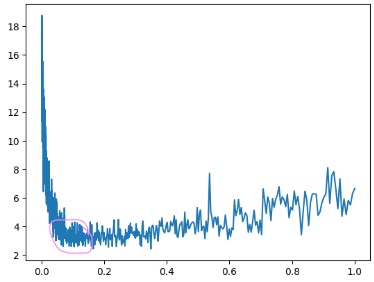

(lre x axis - loss y axis)
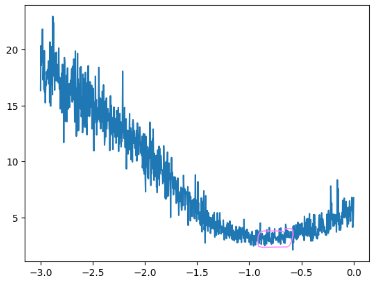

```python
plt.plot(lr_tracking, loss_tracking)
```

so after all 0.1 was a nice lr initialize

In [184]:
#Training

batch_size=64

for i in range(300000):
  
  # minibatch construct, to avoid calculating over all the dataset
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  if i%50000==0:
    print(f"step {i}: {loss.item()}")
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i] #to check the sweet spot of our lr
  lr = 0.1 if i < 200000 else 0.01 #learning rate decay. minimizing our lr in the final steps
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lr_tracking.append(lre[i]) #to check the sweet spot of our lr
  #loss_tracking.append(loss.item())
  stepi.append(i)
  loss_tracking.append(loss.log10().item())

#print(loss.item())


step 0: 30.45340919494629
step 50000: 1.7737616300582886
step 100000: 1.808089017868042
step 150000: 1.795298457145691
step 200000: 1.6809515953063965
step 250000: 1.6624419689178467


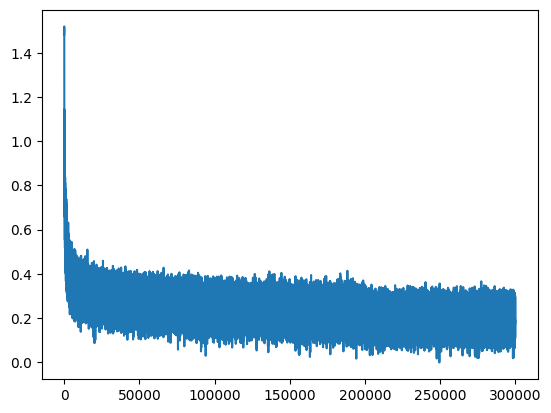

In [185]:
plt.plot(stepi, loss_tracking)

#the noise is due to the minibatches. probably bigger batch size would be recommended

Testing the results

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

#1st iteration: tensor(1.8746, grad_fn=<NllLossBackward0>) with n_neurons=100, n_dimensions=2
#2nd iteration: tensor(1.7772, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=2
#3rd iteration: tensor(1.7877, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=2 batchsize=64
#4rd iteration: tensor(1.6086, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=10 batchsize=64

#note: a slight overfit is recommended

tensor(1.6086, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

#1st iteration: tensor(1.9484, grad_fn=<NllLossBackward0>) with n_neurons=100, n_dimensions=2
#2nd iteration: tensor(1.9003, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=2. higher difference with training
#3rd iteration: tensor(1.9021, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=2 batchsize=. basically no difference
#4rd iteration: tensor(1.8707, grad_fn=<NllLossBackward0>) with n_neurons=300, n_dimensions=10 batchsize=64



tensor(1.8707, grad_fn=<NllLossBackward0>)

Our train loss is smaller than our dev loss

In [ ]:
# we obtained 2.29 with the bigram model
# we clearly improve our results!!! 1.8676
emb = C[Xte]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.8676, grad_fn=<NllLossBackward0>)

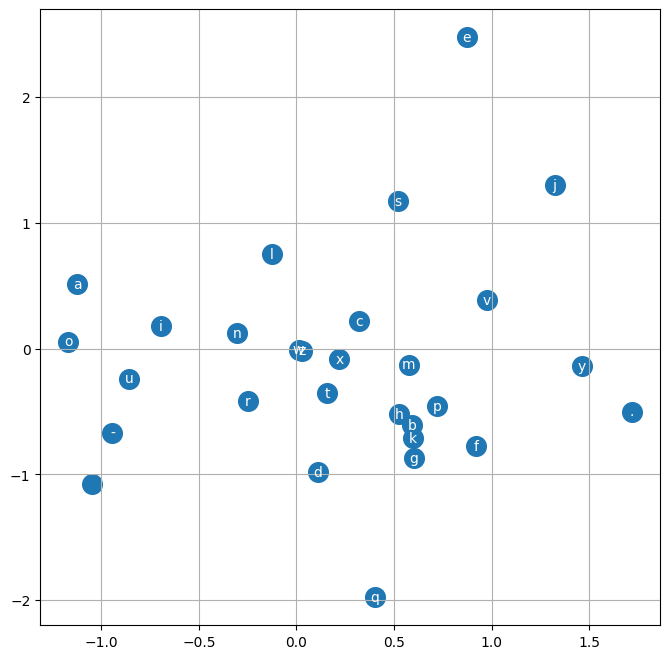

In [ ]:
#Here it is a time capsule of out embedded characters before we upscale to the 10th dimension

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

#e is really curious. proably due to a lots of "de"
#rest of vocals are near
#" " and "-" are 
#z, w and x are close as strange characters

# Finally the best part...sampling the results :)

In [190]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

colinede los catabado de castar.
herres.
montibarcos.
cantanillacava de calenas.
moropedro de taente.
hoya.
harinconono.
rus.
das.
aletbra.
hoyadocin.
pechotorres de lla de los de hertos.
carroy.
latrimes.
nepena.
olina.
canenaga.
san caudillo.
mota del zaut.
abuente.
marta de lasementes.
gredovia.
dudas.
zal.
pica de val de saya.
arcia del mars.
arguerton.
tepal.
ahueca del mea.
sant gany.
esma.
camartena.
aranca.
el estroma.
bergailzada.
cala del castella.
ayegurribado.
ackuia de llangonz guada.
mez.
las ban nieva maszal.
la coles del cardena.
samella masarra.
aguerolanes.
ron.
cin.
luga de llon.
rei.
san juigperes.
zorada de san.
alcazarzobispontriko-urceocina de terroses.
melillares.
almar.
hueta.
bujal.
herra.
santa mayueque.
vilves.
hitorrada de tras.
almosiles.
la pozo de pria de alt.
arcona.
cusan juan de alfaurierra.
bija.
alparejordome de la celi.
vede fuente.
zumiedro.
esguera de tozbarcenc del pueblegordos.
burgel pedras.
urria.
mieunx.
sola zudar.
seres.
cas.
bustillar del